## Load 'jupyter notebook' from Conda Terminal before beginning to use GPU

In [4]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.optimizers import SGD
import numpy as np
import tensorflow as tf
from keras.models import load_model


# Testing to make sure TensorFlow GPU is working
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Tensorflow: ', tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7336789590827771961
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4952306483
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3156192566879497811
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Tensorflow:  1.11.0


### Load data, shuffle data, normalize data, split data into training and validation

In [2]:
from sklearn.utils import shuffle

# Load the data
X_train = np.load("X_mel_train_3.dat")
y_train = np.load("y_mel_train_3.dat")

X_train, y_train = shuffle(X_train, y_train, random_state=16)
# reshape so in form for CNN-Keras
#X_train = X_train.reshape(X_train.shape[0], 174, 124, 1)

# Normalize the data
X_train = X_train/255

print(X_train.shape)
print(y_train.shape)


# split data into validation set
training_set_size = int(X_train.shape[0] * .80)
X_train_validation = X_train[training_set_size:, :,:,:]
y_train_validation = y_train[training_set_size:, :]
y_train = y_train[:training_set_size,:]
X_train = X_train[:training_set_size, :, :, :]
print("Validation x train set:" + str(X_train_validation.shape))
print("X train set:" + str(X_train.shape))
print("Validation y train set:" + str(y_train_validation.shape))
print("Y train set:" + str(y_train.shape))

(9000, 124, 174, 3)
(9000, 10)
Validation x train set:(1800, 124, 174, 3)
X train set:(7200, 124, 174, 3)
Validation y train set:(1800, 10)
Y train set:(7200, 10)


## Build the CNN network

In [5]:
# VGG-16 like network from Andrew Ng's course on Coursera
def build_model():
    model = Sequential()

    # input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    model.add(BatchNormalization(input_shape=X_train.shape[1:]))
    
    model.add(Conv2D(64, (7,7), activation = 'relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

    model.add(Conv2D(128, (7, 7), activation = 'relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())    
    # model.add(Dropout(0.5))

    model.add(Conv2D(256, (7, 7), activation = 'relu', strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

    # model.add(Conv2D(512, (7, 7), activation = 'relu', strides=(1,1)))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.5))

    # model.add(Conv2D(256, (7, 7), activation = 'relu', strides=(1,1)))
    # # # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # # # model.add(Dropout(0.5))

    # # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

## Begin training the model

In [6]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

mcp = ModelCheckpoint("models/best_model_3splits_mel.h5", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

# do crazy image generator stuff to randomize data
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )
generator = gen.flow(X_train, y_train, batch_size = 32)
# end of crazy image genertor stuff


# adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model = build_model()
model.compile(sgd, 'categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(generator, steps_per_epoch=len(X_train)/32, epochs=100, validation_data=(X_train_validation, y_train_validation), 
         callbacks = [mcp])

Epoch 1/100
225/225 [==============================] - 54s 240ms/step - loss: 2.3727 - acc: 0.2464 - val_loss: 1.8749 - val_acc: 0.3317
Epoch 2/100
225/225 [==============================] - 49s 216ms/step - loss: 1.9330 - acc: 0.3249 - val_loss: 1.6849 - val_acc: 0.3972
Epoch 3/100
225/225 [==============================] - 48s 215ms/step - loss: 1.7975 - acc: 0.3731 - val_loss: 1.6865 - val_acc: 0.3878
Epoch 4/100
225/225 [==============================] - 48s 215ms/step - loss: 1.7010 - acc: 0.4001 - val_loss: 1.6132 - val_acc: 0.4083
Epoch 5/100
225/225 [==============================] - 49s 217ms/step - loss: 1.6302 - acc: 0.4279 - val_loss: 1.4376 - val_acc: 0.4833
Epoch 6/100
225/225 [==============================] - 48s 216ms/step - loss: 1.6113 - acc: 0.4286 - val_loss: 1.4825 - val_acc: 0.4683
Epoch 7/100
225/225 [==============================] - 49s 217ms/step - loss: 1.5431 - acc: 0.4606 - val_loss: 1.4499 - val_acc: 0.4772
Epoch 8/100
225/225 [===========================

Epoch 61/100
225/225 [==============================] - 48s 216ms/step - loss: 0.9171 - acc: 0.6932 - val_loss: 0.8857 - val_acc: 0.6833
Epoch 62/100
225/225 [==============================] - 48s 214ms/step - loss: 0.9300 - acc: 0.6889 - val_loss: 0.8622 - val_acc: 0.7028
Epoch 63/100
225/225 [==============================] - 49s 216ms/step - loss: 0.9329 - acc: 0.6882 - val_loss: 0.8588 - val_acc: 0.6922
Epoch 64/100
225/225 [==============================] - 48s 215ms/step - loss: 0.9168 - acc: 0.6894 - val_loss: 0.8548 - val_acc: 0.7017
Epoch 65/100
225/225 [==============================] - 48s 214ms/step - loss: 0.9259 - acc: 0.6857 - val_loss: 0.8707 - val_acc: 0.7089
Epoch 66/100
225/225 [==============================] - 48s 216ms/step - loss: 0.9198 - acc: 0.6925 - val_loss: 0.8279 - val_acc: 0.7217
Epoch 67/100
225/225 [==============================] - 48s 215ms/step - loss: 0.9027 - acc: 0.6964 - val_loss: 0.8076 - val_acc: 0.7178
Epoch 68/100
225/225 [===================

# Delete the below cell

In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

mcp = ModelCheckpoint("models/best_model_3splits_mel.h5", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

# do crazy image generator stuff to randomize data
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )
generator = gen.flow(X_train, y_train, batch_size = 32)
# end of crazy image genertor stuff


# adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model = load_model("models/best_model_3splits_mel.h5")
model.compile(sgd, 'categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(generator, steps_per_epoch=len(X_train)/32, epochs=100, validation_data=(X_train_validation, y_train_validation), 
         callbacks = [mcp])

Epoch 1/100
225/225 [==============================] - 54s 238ms/step - loss: 0.5521 - acc: 0.8147 - val_loss: 0.7215 - val_acc: 0.7583
Epoch 2/100
225/225 [==============================] - 49s 216ms/step - loss: 0.5568 - acc: 0.8189 - val_loss: 0.6804 - val_acc: 0.7694
Epoch 3/100
225/225 [==============================] - 49s 217ms/step - loss: 0.5533 - acc: 0.8149 - val_loss: 0.7528 - val_acc: 0.7506
Epoch 4/100
225/225 [==============================] - 49s 216ms/step - loss: 0.5434 - acc: 0.8194 - val_loss: 0.6099 - val_acc: 0.8011
Epoch 5/100
225/225 [==============================] - 49s 216ms/step - loss: 0.5235 - acc: 0.8233 - val_loss: 0.6872 - val_acc: 0.7661
Epoch 6/100
225/225 [==============================] - 49s 218ms/step - loss: 0.5426 - acc: 0.8208 - val_loss: 0.6453 - val_acc: 0.7878
Epoch 7/100
225/225 [==============================] - 50s 222ms/step - loss: 0.5349 - acc: 0.8237 - val_loss: 0.6041 - val_acc: 0.8067
Epoch 8/100
225/225 [===========================

KeyboardInterrupt: 

In [13]:
model.save("models/trained_music_classifier.h5")

## Evaluate the model

In [57]:
score = model.evaluate(X_train_validation, y_train_validation, batch_size=32, verbose=1)
print(score)

50/50 [==============================] - 0s 1ms/step
[3.419465198516846, 0.5800000071525574]


### Reset Keras

In [53]:
from keras import backend as K
K.clear_session()

## Build second classifier, ANN

In [ ]:
ann_model = Sequential()

ann_model.add(Flatten())
ann_model.add(Dense(512, activation = 'relu', input_shape = X_train.shape[1:]))
#ann_model.add(Dropout(0.5))

ann_model.add(Dense(256, activation = 'relu'))
#ann_model.add(Dropout(0.5))

ann_model.add(Dense(128, activation = 'relu'))
#ann_model.add(Dropout(0.5))

ann_model.add(Dense(64, activation = 'relu'))
#ann_model.add(Dropout(0.5))

ann_model.add(Dense(10, activation = 'softmax'))

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

mcp = ModelCheckpoint("models/best_model_2splits_50epochs_highLR", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

#adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

# Using custom adam is horrifically bad for ANN...
ann_model.compile('adam', 'categorical_crossentropy',metrics=['accuracy'])

ann_model.fit(X_train, y_train, batch_size=32, epochs=50 , validation_data=(X_train_validation, y_train_validation), 
         callbacks = [mcp])

## Notes:
#### Default adam optimizer, 1 conv layer 128, and a FC layer of 128:
    - No convergence
#### Default adam optimizer, 2 conv layer 8 filters, and a FC layer of 16:
    - No convergence
#### Default adam optimizer, 2 conv layers and a FC layer of 64 neurons:
    - No dropout or BN
        - 99% train_acc, 60% val_acc, 10 epochs
    - Using BatchNormalization
        - BN at only FC layer overfit extremely fast and was stuck at about 53% val_acc
        - BN at every layer still overfits extremely fast but gets to about 68% val_acc
    - No BN, adding Dropout
        - 0.75 dropout on just the dense layer before softmax -> 83% train_acc and 57% val_acc, in about 10 epochs
        - 0.25 dropout on last layer, get about 97% train_acc with 54% val_acc -> in about 10 epochs
        - 0.25 dropout on every layer, 100 epochs: 97% train_Acc with 60% val_acc
        - 0.25 dropout on hidden layers, 0.5 dropout on output layer, 100 epochs: 80% train_acc and 58% val_acc
        - 0.25 dropout on hidden layers, 0.35 dropout on output layer, 100 epochs: 97% train_acc and 58% val_acc
#### Adam optimizer, LR = 0.0001, 2 conv layers and a FC layer of 64 neurons:
    - No dropout or BN
        - 99% train_acc, 62% val_acc, 20 epochs **not jumpy val_acc** -> starts going down after iteration 29
        
#### Adam optimizer, LR = 0.00001, 2 conv layers and a FC layer of 64 neurons:
    - No dropout or BN
        - Still gets up to 99% acc in about 25 epochs
        
#### SGD, sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), 5-layer CNN, 64-256, FC 1024
    - Dropout only on FC layer 0.5
    - BatchNormalization after each activation

## Plot confusion matrix

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 118, 168, 64)      9472      
_________________________________________________________________
batch_normalization_17 (Batc (None, 118, 168, 64)      256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 59, 84, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 53, 78, 128)       401536    
_________________________________________________________________
batch_normalization_18 (Batc (None, 53, 78, 128)       512       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 39, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 33, 256)       1605888   
__________

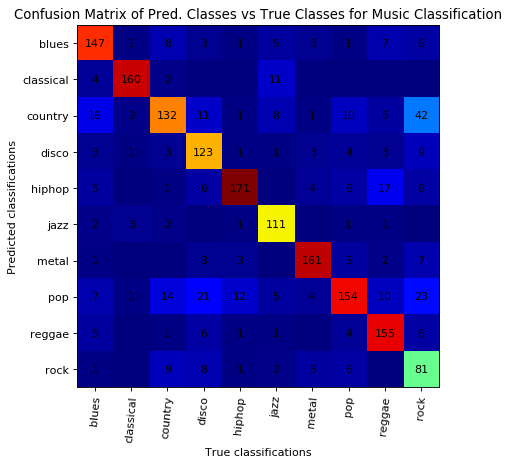

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# build_confusion_matrix()
# Builds the confusion matrix for either naive bayes' or logistic regression.
# Our goal is to have a strong diagonal which corresponds to good correlation
# between validation data classifications and our predictions.
# true_classes are the classifications for the predictions and classes are the total range of classes
def build_confusion_matrix(predictions, true_classes, classes, file_name):
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype='int')
    len_pred = len(predictions)
    print(true_classes)
    # for every class prediction and true class value
    for i in range(len_pred):
        true_classification = np.where(true_classes[i]==1)
#         print(true_classification)
        # we hope that these two are equal for a strong diagonal correlation
        confusion_matrix[predictions[i], true_classification] += 1

    confusion_matrix_df = pd.DataFrame(confusion_matrix, index= classes)
    axis_label = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(confusion_matrix_df.values, cmap='jet', interpolation='nearest')
    plt.xticks(np.arange(10), axis_label, rotation='85')
    plt.yticks(np.arange(10), axis_label)
    plt.tick_params(axis='both', labelsize='10')
    plt.xlabel("True classifications")
    plt.ylabel("Predicted classifications")
    plt.title("Confusion Matrix of Pred. Classes vs True Classes for Music Classification")
#     plt.tight_layout()
    for (j, i), label in np.ndenumerate(confusion_matrix):
        if label != 0:
            plt.text(i,j,label,ha='center',va='center', size='10')
    plt.show()

    confusion_matrix_df.to_csv(file_name, sep=",", header=classes)

model = load_model("models/best_model_3splits_mel.h5")
model.summary()

predictions = model.predict_classes(X_train_validation, verbose=1)
print(predictions)

build_confusion_matrix(predictions, y_train_validation, np.arange(0,10), "confusion_matrix_csv")


## Cross-validation neural network evaluating

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

num_of_folds = 10
total_examples = len(X_train)
size_of_one_fold = total_examples / 10

mcp = ModelCheckpoint("models/best_model_3splits_mel.h5", monitor='val_acc', verbose=0, 
                      save_best_only=True, save_weights_only=False, mode='max', period=1)

# adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


# training[:(i-1) * 900] + training[i * 900:]
# validation[(i-1) * 900: i*900]

for i in range(1, num_of_folds+1):
#     print(X_train.shape)
    print("\nFold " + str(i))
    
    # do cross validation stuff
    
    X_train_fold = np.concatenate((X_train[:((i-1) * 900), :, :, :], X_train[(i * 900):, :, :, :]))
    y_train_fold = np.concatenate((y_train[:((i-1) * 900), :], y_train[(i * 900):, :]))
    
    X_train_validation_fold = X_train[((i-1) * 900) : (i * 900), :, :, :]
    y_train_validation_fold = y_train[((i-1) * 900) : (i * 900), :]
    print("Validation x train set:" + str(X_train_validation_fold.shape))
    print("X train set:" + str(X_train_fold.shape))
    print("Validation y train set:" + str(y_train_validation_fold.shape))
    print("Y train set:" + str(y_train_fold.shape) + "\n")
    
    # end cross-validation
    
    # get new model to train on
    model = build_model()
    
    model.compile(sgd, 'categorical_crossentropy',metrics=['accuracy'])
    
    model.fit(X_train_fold, y_train_fold, batch_size=32, epochs=3 , validation_data=(X_train_validation_fold, 
            y_train_validation_fold), callbacks = [mcp])